<a href="https://colab.research.google.com/github/Basel-byte/Network-Anomaly-Detection/blob/Kmean/Pr_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice Lab: Clustering  

In this exercise, we will know how K-Means and Normalized Cut algorithms can be used for network anomaly detection.

# Outline
- [ 1 - Extracting Dataset](#1)
- [ 2 - Packages ](#2)
- [ 3 - Reading data and Preprocessing](#3)
  - [3.1 Reading Columns' Names](#3.1)
  - [3.2 Reading dataset](#3.2)
  - [3.3 Removing class column](#3.3)
  - [3.4 Changing Categorical features to numericals](#3.4)
- [ 4 - K-means](#4)
- [ 5 - Spectral Clustering](#5)
  - [5.1 Getting Laplacian and Degree Matrices](#5.1)
  - [5.2 Spectral Clustering Algorithm](#5.2)
- [ 6 - New Clustering Algorithm](#6)
- [ 7 - Clustering Evaluation](#7)
  - [ 7.1 - Getting Predicted labels](#7.1)
  - [ 7.2 - Precision Measure](#7.2)
  - [ 7.3 - Recall Measure](#7.3)
  - [ 7.4 - F1 Measure](#7.4)
  - [ 7.5 - Entropy Measure](#7.5)
  

  

<a name="1"></a>
## 1 - Extracting Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gzip -d /content/drive/MyDrive/kddcup.data.gz

gzip: /content/drive/MyDrive/kddcup.data.gz: No such file or directory


<a name="2"></a>
## 2 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
<!-- - [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python. -->
<!-- - [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning. -->
- [pandas](https://pandas.pydata.org/) is open source data analysis and manipulation tool.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
from scipy.spatial.distance import cdist
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import eigh
from scipy.stats import mode
from sklearn.cluster import KMeans

<a name="3"></a>
## 3 - Reading data and Preprocessing

<a name="3.1"></a>
#### Reading columns' names 

In [3]:
DATASET_COLUMNS_FILE = "/content/drive/MyDrive/kddcup1999_columns.txt"
column_types =[]

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[:]:
    match = column_regex.match(column_type)
    column_types.append(match.group("column_name"))
del column_labels

<a name="3.2"></a>
#### Reading the training dataset

In [4]:
data = pd.read_csv("/content/drive/MyDrive/kddcup.data", header=None)
data.columns = column_types

<a name="3.3"></a>
#### Removing class column

In [5]:
data_without_labels = data.drop(columns=["class"])
labels = data["class"]
del data
del column_types

<a name="3.4"></a>
### Change the categorical features to numericals

In [6]:
def convert_string_to_numeric(data_frame):
  # df_copy = data_frame.copy()
  my_dict = None
  for col in data_frame:
    if data_frame[col].dtypes == object:
      my_dict = {elem: index for index, elem in enumerate(data_frame[col].unique())}
      data_frame[col].replace(my_dict, inplace=True)
  return data_frame, my_dict

In [7]:
def convert_string_to_binary_numeric(data_frame):
  # df_copy = data_frame.copy()
  for col in data_frame:
    if data_frame[col].dtypes == object:
      df1 = pd.get_dummies(data_frame[col])
      data_frame = pd.concat([data_frame, df1], axis=1).reindex(data_frame.index)
      data_frame.drop(col, axis=1, inplace=True)
  return data_frame

In [8]:
# use either of them but not both
# convert_string_to_numeric(data_without_labels.copy())

data_without_labels = convert_string_to_binary_numeric(data_without_labels).values.astype(np.float32)

<a name="4"></a>
## 4 - Kmeans



In [10]:
class new_KMeans:
    lables = None
    def __init__(self, k=2, max_iter=50,centroids = None):
        self.k = k
        self.max_iter = max_iter
        self.centroids = centroids
    def predict(self, array):
      distances = cdist(array, self.centroids)
      nearest_rows = np.argmin(distances, axis=1)
      return nearest_rows

    def compute_centroid(self,data_frame):
      data_unique = data_frame.values
      centroids = np.array([])
      shape = (0, data_unique.shape[1])  # 0 rows, 4 columns
      # Create empty numpy array
      centroids = np.empty(shape)
      # random intialization
      if self.centroids == None:
        while centroids.shape[0] < self.k:
          i = random.randint(0,len(data_unique)-1)
          centroids = np.vstack([centroids, data_unique[i]])
          # print(centroids.shape)
          if self.k == centroids.shape[0] :
            centroids = np.unique(centroids,axis=0)
        iter = 0
      nearest_rows = np.zeros((data_unique.shape[0]))
      while True:
        iter += 1
        distances = cdist(data_unique, centroids)
        # Find index of row with minimum distance for each row of arr1
        old_nearest = nearest_rows
        nearest_rows = np.argmin(distances, axis=1)
        clustering  = [[] for _ in range(self.k)]
        print(nearest_rows)
        # for i in range(len(nearest_rows)):
        #   clustering[nearest_rows[i]].append(data_unique[i])
        # old_centroids = centroids
        # centroids = np.empty(shape)
        # for i in clustering:
        #   new_centroid = np.mean(i, axis=0)
        #   centroids = np.vstack([centroids, new_centroid])
        old_centroids = centroids
        centroids = np.array([data_unique[nearest_rows == j].mean(axis=0) for j in range(self.k)])
        diff = np.abs(old_centroids - centroids)
        # print(diff)
        # Find the maximum difference
        max_diff = np.amax(diff)
        diff_near = np.abs(old_nearest - nearest_rows)
        diff_near = np.amax(diff_near)
        # print(diff)
        # Find the maximum difference
        max_diff = np.amax(diff)
        if max_diff < 1e-10 or diff_near == 0 or iter == self.max_iter:
          break
      # print(iter)
      print(f"Number of iterations = {iter}")
      return nearest_rows ,centroids
    def compute_error(self,data,predictions,centroids):
      distances = np.zeros(len(data))
      for i, (x, y) in enumerate(zip(data, predictions)):
        distances[i] = np.linalg.norm(x - centroids[y])
      mean_error = np.mean(distances)
      return mean_error
    def train(self,data_frame,k = 5):
      min_lables,min_centroids = self.compute_centroid(data_frame)
      min = self.compute_error(data_frame.values, min_lables, min_centroids)
      print(min)
      for i in range(1,k):
        lables,centroids= self.compute_centroid(data_frame)
        error = self.compute_error(data_frame.values, lables, centroids)
        if(error < min):
          min = error
          min_centroids = centroids
          min_lables = lables
      self.centroids = min_centroids
      self.lables = min_lables
      return self.lables

### Testing With diffrent k

In [11]:
def test_with_k(K, data_without_strings):
    train = new_KMeans(K)
    st = time.time()
    lables= train.train(data_without_strings)
    total_time = time.time() - st
    kmean_data_frame = pd.DataFrame(lables)
    print(kmean_data_frame)
    kmean_data_frame.columns = ["labels"]
    counts = kmean_data_frame['labels'].value_counts()
    print("Kmean cluster result")
    print(counts)
    print(f"Time in seconds = {total_time}")
    kmeans = KMeans(n_clusters=K)
    # fit the KMeans object to the data
    st = time.time()
    kmeans.fit(data_without_strings.values)
    centroids = kmeans.cluster_centers_
    skLearn_labels =kmeans.predict(data_without_strings.values)
    total_time = time.time() - st

    skLearn_labels_dataFrame = pd.DataFrame(skLearn_labels)
    skLearn_labels_dataFrame.columns = ["labels"]
    dfunique_values = skLearn_labels_dataFrame['labels'].unique()
    sklearn_counts = skLearn_labels_dataFrame['labels'].value_counts()
    print("skLearn function")
    print(sklearn_counts)
    print(f"Time in seconds = {total_time}")
    return train

In [ ]:


DATASET_COLUMNS_FILE = "/home/elsaber/pr assign/cluster/kddcup1999_columns.txt"
column_types =[]

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[:]:
    match = column_regex.match(column_type)
    column_types.append(match.group("column_name"))



data_10 = pd.read_csv("/home/elsaber/pr assign/cluster/kddcup.data_10_percent_corrected", header=None)
data_10.columns = column_types


data_without_10_labels = data_10.drop(columns=["class"])

labels_10 = data_10["class"]
data_10_numeric = convert_string_to_binary_numeric(data_without_10_labels)
data_10_numeric.insert(44, "aol", 0)
data_10_numeric.insert(63, "harvest", 0)
data_10_numeric.insert(66, "http_2784", 0)
data_10_numeric.insert(68, "http_8001", 0)





#### K = 7

In [ ]:
kmean_7= test_with_k(7, data_10_numeric)


[3 0 3 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 2 1 ... 1 1 1]
[1 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
Number of iterations = 32
1690.0888128996303
[3 0 3 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 2 1 ... 1 1 1]
[1 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[1 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[2 2 2 ... 2 2 2]
[

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
0    493827
6        72
2        59
4        24
5        20
3        18
1         1
Name: labels, dtype: int64
Time in seconds = 11.684958696365356


#### K = 15

In [ ]:
kmean_15=test_with_k(15, data_10_numeric)

[6 5 7 ... 7 7 7]
[7 5 7 ... 7 7 7]
[7 5 5 ... 5 5 5]
[7 5 5 ... 5 5 5]
[7 2 5 ... 5 5 5]
[5 2 5 ... 5 5 5]
[5 2 2 ... 2 2 2]
[5 2 2 ... 2 2 2]
[5 3 2 ... 2 2 2]
[2 3 2 ... 2 2 2]
[2 3 2 ... 3 3 3]
[2 3 3 ... 3 3 3]
[2 3 3 ... 3 3 3]
[2 3 3 ... 3 3 3]
[2 4 3 ... 3 3 3]
[3 4 3 ... 3 3 3]
[3 4 3 ... 4 4 4]
[3 4 4 ... 4 4 4]
[3 4 4 ... 4 4 4]
[3 4 4 ... 4 4 4]
[3 4 4 ... 4 4 4]
[3 4 4 ... 4 4 4]
[3 4 4 ... 4 4 4]
[3 4 4 ... 4 4 4]
[3 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 4]
[ 4 10 10 ... 10 10 10]
[ 4 10 10 ... 10 10 10]
Number of iterations = 50
729.2468362904038
[9 5 6 ... 6 6 6]
[9 0 6 ... 6 6 6]
[9 0 6 .

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
0     480134
13      9952
7       2334
12      1369
14        72
2         59
4         24
9         22
3         16
11        12
6         11
8          8
5          5
10         2
1          1
Name: labels, dtype: int64
Time in seconds = 21.480437994003296


#### K = 23


In [ ]:
kmean_23=test_with_k(23, data_10_numeric)

[ 8 10  5 ...  7  7  5]
[ 9 10  5 ...  7  7  7]
[ 9 10  5 ...  7  7  7]
[ 9 10  5 ...  7  7  7]
[ 9 10  5 ...  7  7  7]
[19 10  7 ...  7  7  7]
[19 10  7 ...  7  7  7]
[19 10  7 ...  7  7  7]
[19 10  7 ...  7  7  7]
[19 10  7 ...  7  7  7]
[ 5 10  7 ...  7  7  7]
[ 5 10  7 ...  7  7  7]
[ 5 10  7 ...  7  7  7]
[ 5 10  7 ...  7  7  7]
[ 5 10  7 ... 10 10 10]
[ 5 10 10 ... 10 10 10]
[ 7 10 10 ... 10 10 10]
[ 7  0 10 ... 10 10 10]
[ 7  0 10 ... 10 10 10]
[ 7  0 10 ... 10 10 10]
[ 7  0 10 ... 10 10 10]
[ 7  0 10 ... 10 10 10]
[7 0 0 ... 0 0 0]
[7 0 0 ... 0 0 0]
[10  0  0 ...  0  0  0]
[10  1  0 ...  0  0  0]
[10  1  0 ...  0  0  0]
[10  1  0 ...  0  0  0]
[10  1  0 ...  0  0  0]
[10  1  0 ...  0  0  0]
[10  1  0 ...  0  0  0]
[10  1  0 ...  1  1  1]
[10  1  1 ...  1  1  1]
[10  1  1 ...  1  1  1]
[10  1  1 ...  1  1  1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 1 1 1]
[0 2 1 ... 2 2 2]
[0 2 2 ... 2 2 2]
[0 2 2 ... 2 2 2]
[0 2 2 ...

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
15    290672
0     179008
19     13492
16      5185
7       2314
13      1650
22      1020
11       377
20        69
2         59
9         44
4         24
18        21
21        19
3         16
6         13
17        10
8          8
12         8
5          5
14         4
10         2
1          1
Name: labels, dtype: int64
Time in seconds = 27.094157934188843


#### K = 31


In [ ]:
kmean_31=test_with_k(31, data_10_numeric)

[18 14 16 ... 16 16 16]
[18 14 16 ... 16 16 16]
[20 14 16 ... 17 17 16]
[20 14 16 ... 17 17 17]
[20 14 17 ... 17 17 17]
[20 14 17 ... 17 17 17]
[16 14 17 ... 17 17 17]
[16 15 17 ... 17 17 17]
[16 15 17 ... 14 14 17]
[16 15 14 ... 14 14 14]
[16 15 14 ... 14 14 14]
[17 15 14 ... 14 14 14]
[17 15 14 ... 14 14 14]
[17 15 14 ... 14 14 14]
[17 15 14 ... 14 14 14]
[17 15 14 ... 15 15 14]
[17 15 15 ... 15 15 15]
[14 15 15 ... 15 15 15]
[14  1 15 ... 15 15 15]
[14  1 15 ... 15 15 15]
[14  1 15 ... 15 15 15]
[14  1 15 ... 15 15 15]
[14  1 15 ...  1  1  1]
[14  1  1 ...  1  1  1]
[14  9  1 ...  1  1  1]
[15  9  1 ...  1  1  1]
[15  9  1 ...  1  1  1]
[15  9  1 ...  1  1  1]
[15  9  1 ...  1  1  1]
[15  9  1 ...  1  1  1]
[15  9  1 ...  9  9  9]
[15  9  9 ...  9  9  9]
[15  4  9 ...  9  9  9]
[15  4  9 ...  9  9  9]
[15  4  9 ...  9  9  9]
[1 4 9 ... 9 9 9]
[1 4 9 ... 9 9 9]
[1 4 9 ... 9 9 9]
[1 4 9 ... 9 9 9]
[1 4 9 ... 4 4 9]
[1 4 9 ... 4 4 4]
[1 4 4 ... 4 4 4]
[1 4 4 ... 4 4 4]
[ 1 11  4 ...  4

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
0     289531
19    176783
21     14759
14      5409
8       2308
22      1648
26      1261
24      1017
11       762
28       235
2         59
15        56
27        32
9         29
4         23
17        21
3         16
29        12
20        11
13         9
5          9
16         7
25         6
6          5
7          3
18         3
10         2
23         2
1          1
30         1
12         1
Name: labels, dtype: int64
Time in seconds = 38.28031539916992


#### K = 45


In [ ]:
kmean_45=test_with_k(45, data_10_numeric)

[25 30 34 ... 33 33 33]
[25 30 34 ... 34 34 34]
[25 30 34 ... 34 34 34]
[25 30 34 ... 34 34 34]
[25 30 34 ... 34 34 34]
[25 30 34 ... 34 34 34]
[25 30 34 ... 34 34 34]
[25 30 34 ... 34 34 34]
[25 30 34 ... 34 34 34]
[25 30 34 ... 34 34 34]
[26 30 34 ... 34 34 34]
[26 30 34 ... 34 34 34]
[26 30 34 ... 34 34 34]
[26 30 34 ... 34 34 34]
[26 33 34 ... 34 34 34]
[26 22 34 ... 34 34 34]
[29 22 34 ... 34 34 34]
[29 22 34 ... 34 34 34]
[29 22 34 ... 33 33 34]
[29 22 34 ... 33 33 34]
[29 22 34 ... 33 33 33]
[29 22 34 ... 33 33 33]
[29 22 33 ... 33 33 33]
[29 22 33 ... 33 33 33]
[29 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[27 22 33 ... 33 33 33]
[34 18 33 ... 22 22 22]
[34 18 22 ... 22 22 22]
[34 18 22 ... 22 22 22]
[34 18 22 ... 22 22 22]
[34 18 22 ... 22 22 22]
[34 18 22 ... 22

/tmp/ipykernel_71915/733219731.py:44: RuntimeWarning: Mean of empty slice.
  centroids = np.array([data_unique[nearest_rows == j].mean(axis=0) for j in range(self.k)])
/home/elsaber/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[40 40 40 ... 40 40 40]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
Number of iterations = 50
[26 20 30 ... 31 31 31]
[25 21 30 ... 31 31 30]
[25 21 30 ... 31 31 30]
[25 21 30 ... 30 30 30]
[24 21 3

/home/elsaber/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


skLearn function
15    289886
0     158718
31     21273
18      6500
42      4225
32      3032
13      2507
7       2211
22      1275
37      1255
23       942
39       788
9        493
25       223
36       191
40       104
16        65
2         59
38        43
33        35
44        24
4         23
20        22
19        21
11        18
3         16
24        11
35         9
28         8
12         7
29         5
14         4
6          4
5          4
21         4
8          3
34         3
17         2
10         2
43         1
1          1
41         1
30         1
26         1
27         1
Name: labels, dtype: int64
Time in seconds = 49.92401909828186


<a name="5"></a>
## 5 - Spectral clustering


<a name="5.1"> </a>
### 5.1 Getting Laplacian and Similarity Matrices

In [9]:
def get_laplacian_degree(data_no_label, gamma=0.1):
  sim_matrix = rbf_kernel(data_no_label, gamma=gamma)
  del data_no_label
  sim_matrix = np.add(sim_matrix, np.finfo(sim_matrix.dtype).eps)
  np.fill_diagonal(sim_matrix, 0)
  deg_matrix = np.sum(sim_matrix, axis=1)
  np.fill_diagonal(sim_matrix, deg_matrix)
  print(deg_matrix[deg_matrix == 0].shape, np.mean(deg_matrix))
  return sim_matrix, np.diag(deg_matrix)

<a name="5.2"></a>
### 5.2 Spectral Clustering Algorithm

In [10]:
def spectral_clustering(data_no_label, k = 3):
  data_no_label, dummy = train_test_split(data_no_label, train_size=0.0015, random_state=42, stratify=labels)
  del dummy
  laplacian_mat, degree_mat = get_laplacian_degree(data_no_label) # deg_mat is a vector
  eigenvalues, eigenvectors = eigh(laplacian_mat, degree_mat)
  del eigenvalues
  eigenvectors = eigenvectors[:, :k] / np.linalg.norm(eigenvectors[:, :k], ord=2, axis=1, keepdims=True)
  # to use the implemented kmeans, remove the next 3 lines and use the commented one
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(eigenvectors)
  return kmeans.labels_
  # return Kmeans(eigenvectors, k)

<a name="7"></a>
## 7- Clustering Evaluation

<a name="7.1"></a>
### 7.1 - getting predicted labels

In [11]:
c_labels = spectral_clustering(data_without_labels, 11)
unique_elements, counts = np.unique(c_labels, return_counts=True)
print(unique_elements, counts)

(0,) 1511.485


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 0  1  2  3  4  5  6  7  8  9 10] [1044 1268  336  715  432  335  300  366  316  452 1783]


In [12]:
# run this line in spectral clustering 
labels_m = train_test_split(labels, train_size=0.0015, random_state=42, stratify=labels)[0]
labels_m, dict = convert_string_to_numeric(pd.DataFrame(labels_m))
labels_m = labels_m.values
labels_m = labels_m.reshape(labels_m.size)
counts = np.unique(labels_m, return_counts=True)[1]
dict = {value: key for key, value in dict.items()}

<a name="7.2"></a>
### 7.2 - Recall Measure


In [13]:
def measure_recall(real_labels, predicted_labels, counts):
  sum = 0;
  unique_predic = np.unique(predicted_labels)
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    major_class = mode(cluster, axis=None, keepdims=True)
    #print(major_class.count[0] / counts[major_class.mode[0]])
    sum += major_class.count[0] / counts[major_class.mode[0]]
  return sum / unique_predic.size

# print(measure_recall(labels, c_labels))

<a name="7.3"></a>
### 7.3 - Precision Measure

In [14]:
def measure_precision(real_labels, predicted_labels, dict):
  sum = 0;
  unique_predic = np.unique(predicted_labels)
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    major_class = mode(cluster, axis=None, keepdims=True)
    print(f'major anomaly in this cluster is {dict.get(major_class.mode[0])} with ratio {major_class.count[0] / cluster.size}')
    sum += major_class.count[0] / cluster.size
  return sum / unique_predic.size
# print(measure_precision(labels, c_labels))

<a name="7.4"></a>
### 7.4 F1 Score

In [15]:
def measure_f1(real_labels, predicted_labels,counts):
  sum = 0;
  unique_predic = np.unique(predicted_labels)
  #print(unique_predic)
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    major_class = mode(cluster, axis=None, keepdims=True)
    #print(major_class.count[0] / cluster.size, ", ", major_class.count[0] / counts[major_class.mode[0]])
    recall = major_class.count[0] / counts[major_class.mode[0]]
    precis = major_class.count[0] / cluster.size
    sum += (2 * recall * precis) / (recall + precis)
  return sum / unique_predic.size
# print(measure_f1(labels, c_labels))

<a name="#7.5"></a>
### 7.5 Conditional Entropy

In [16]:
def measure_entropy(real_labels, predicted_labels):
  unique_predic = np.unique(predicted_labels)
  total_entropy = 0
  for c_label in unique_predic:
    cluster = real_labels[np.array(np.where(predicted_labels == c_label)[0].tolist())]
    probs_in_cluster = np.unique(cluster, return_counts = True)[1] / cluster.size
    probs_in_cluster = probs_in_cluster * np.log2(probs_in_cluster) 
    cluster_cond_entropy = -np.sum(probs_in_cluster)
    #print(cluster_cond_entropy)
    total_entropy += (cluster.size / real_labels.size * cluster_cond_entropy)
  return total_entropy
# print(measure_entropy(labels, c_labels))

In [18]:
def test_spectral(labels, predicted_labels, dict, counts):
  print('for Spectral Clustering')
  print(f'precision:\n {measure_precision(labels, predicted_labels, dict)}')
  print(f'recall:\n {measure_recall(labels, predicted_labels, counts)}')
  print(f'f1:\n {measure_f1(labels, predicted_labels, counts)}')
  print(f'entropy:\n {measure_entropy(labels, predicted_labels)}')

test_spectral(labels_m, c_labels, dict, counts)

for Spectral Clustering
major anomaly in this cluster is smurf. with ratio 0.9664750957854407
major anomaly in this cluster is normal. with ratio 0.9503154574132492
major anomaly in this cluster is smurf. with ratio 0.8005952380952381
major anomaly in this cluster is smurf. with ratio 0.8195804195804196
major anomaly in this cluster is smurf. with ratio 0.7916666666666666
major anomaly in this cluster is neptune. with ratio 0.6865671641791045
major anomaly in this cluster is neptune. with ratio 0.8366666666666667
major anomaly in this cluster is neptune. with ratio 0.7240437158469946
major anomaly in this cluster is neptune. with ratio 0.629746835443038
major anomaly in this cluster is neptune. with ratio 0.7057522123893806
major anomaly in this cluster is smurf. with ratio 0.971396522714526
precision:
 0.8075278177073385
recall:
 0.23155887285554136
f1:
 0.33037735480844516
entropy:
 0.6150985021358674


In [ ]:
def testKmeans(kmean, labels,data):
    pL=kmean.predict(data)
    kmean_data_frame = pd.DataFrame(pL)
    kmean_data_frame.columns = ["labels"]
    labels, dict = convert_string_to_numeric(pd.DataFrame(labels))
    dict = {value: key for key, value in dict.items()}
    labels = labels.values
    labels = labels.reshape(labels.size)
    print(labels)
    counts = np.unique(labels, return_counts=True)[1]
    print("Kmean prediction result")
    print("Kmean recall result")
    recall = measure_recall(labels,pL,counts)
    print(recall)
    print("Kmean precision result")
    precision = measure_precision(labels, pL, dict)
    print(precision)
    print("Kmean f1 result")
    f1 = measure_f1(labels, pL,counts)
    print(f1)

    print("Kmean entropy result")
    entropy = measure_entropy(labels, pL)
    print(entropy)
    return recall,precision,f1,entropy

In [ ]:
pL=kmean_7.predict(data_10_numeric)

kmean_data_frame = pd.DataFrame(pL)
kmean_data_frame.columns = ["labels"]
labels_10, dict = convert_string_to_numeric(pd.DataFrame(labels_10))
dict = {value: key for key, value in dict.items()}
labels_10 = labels_10.values
labels_10 = labels_10.reshape(labels_10.size)
print(labels_10)
counts = np.unique(labels_10, return_counts=True)[1]
print("Kmean prediction result")
print("Kmean recall result")

print(measure_recall(labels_10,pL,counts ))
print("Kmean precision result")
print(measure_precision(labels_10, pL, dict))
print("Kmean f1 result")
print(measure_f1(labels_10, pL,counts))

print("Kmean entropy result")
print(measure_entropy(labels_10, pL))

[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.40191156569359093
Kmean precision result
0.8353976836704948
Kmean f1 result
0.368389964834723
Kmean entropy result
1.51127225826043


In [ ]:
testKmeans(kmean_7, labels_10,data_10_numeric)

[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.40154178427155635
Kmean precision result
0.8532636927631048
Kmean f1 result
0.3683647301547576
Kmean entropy result
0.6920353247334791


(0.40154178427155635,
 0.8532636927631048,
 0.3683647301547576,
 0.6920353247334791)

Test all k in kmean

In [ ]:
def tesK():
    DATASET_COLUMNS_FILE = "/home/elsaber/pr assign/cluster/kddcup1999_columns.txt"
    column_types =[]
    with open(DATASET_COLUMNS_FILE, 'r') as file:
        column_labels: str = file.read()
    column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
    for column_type in column_labels.splitlines()[:]:
        match = column_regex.match(column_type)
        column_types.append(match.group("column_name"))
    test_data = pd.read_csv("/home/elsaber/pr assign/cluster/kddcup.data.corrected", header=None)
    test_data.columns = column_types
    data_without_labels = test_data.drop(columns=["class"])
    labels = test_data["class"]
    data_numeric = convert_string_to_binary_numeric(data_without_labels)
    recalls = []
    precisions = []
    f1s = []
    entropies =[]
    ans = testKmeans(kmean_7, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    ans = testKmeans(kmean_15, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    ans = testKmeans(kmean_23, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    ans = testKmeans(kmean_31, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    ans = testKmeans(kmean_45, labels,data_numeric)
    recalls.append(ans[0])
    precisions.append(ans[1])
    f1s.append(ans[2])
    entropies.append(ans[3])
    del test_data
    return recalls,precisions,f1s,entropies


In [ ]:
recalls,precisions,f1s,entropies = tesK()

[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.2520076607022184
Kmean precision result
0.7611642307433313
Kmean f1 result
0.1907225995414563
Kmean entropy result
1.4755889483673017
[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.2705874918908328
Kmean precision result
0.8850936599819665
Kmean f1 result
0.24243350953088738
Kmean entropy result
0.5162145202604359
[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.20337141317366014
Kmean precision result
0.9389925065783832
Kmean f1 result
0.22149533140769465
Kmean entropy result
0.1452851694092668
[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.18020982607853545
Kmean precision result
0.9508182347411253
Kmean f1 result
0.21839859306946688
Kmean entropy result
0.06056541368142795
[0 0 0 ... 0 0 0]
Kmean prediction result
Kmean recall result
0.12386966878587825
Kmean precision result
0.9441945068122829
Kmean f1 result
0.15710784511639928
Kmean entropy result
0.05302647671599356


In [ ]:
k = [7,15,23,31,45]


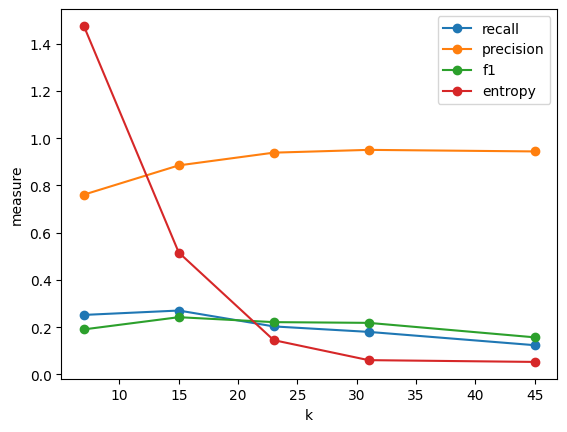

In [ ]:
plt.plot(k, recalls, '-o')
plt.plot(k, precisions, '-o')
plt.plot(k, f1s, '-o')
plt.plot(k, entropies, '-o')
plt.legend(["recall","precision","f1", "entropy"])
plt.xlabel('k')
plt.ylabel('measure')
plt.show()